# Experiment 6

In [203]:
import numpy as np
from matplotlib import pyplot as plt
from lmfit.models import GaussianModel
from scipy.optimize import curve_fit

### 1. Finding the Gaussian fit frequency and width

In [204]:
def fit_gaussian(x, y):
    gm = GaussianModel()
    pars = gm.guess(y, x=x)
    out = gm.fit(y, pars, x=x)
    mean = out.best_values['center']
    sigma = out.best_values['sigma']
    return mean, sigma, out.best_fit

def gaussian(x, mean, sigma, baseline):
    return baseline + np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_gaussian_with_baseline(x, y):
    mean, sigma, baseline = curve_fit(gaussian, x, y)[0]
    return mean, sigma, baseline

In [205]:
# Loading the data

# For absorption
abs_xy_values_pair = np.loadtxt('1822-096.H1.abs', usecols=(1,2))
abs_x_values = abs_xy_values_pair[:,0]/1e+6 # in MHz
abs_y_values = abs_xy_values_pair[:,1]

# For emission (RR and LL averaged)
ems_xy_values_pair_LL = np.loadtxt('LL_1822-096.self.spec', usecols=(3,5))
ems_xy_values_pair_RR = np.loadtxt('RR_1822-096.self.spec', usecols=(3,5))
ems_xy_values_pair = (ems_xy_values_pair_LL + ems_xy_values_pair_RR)/2
ems_x_values = ems_xy_values_pair[:,0] # in MHz
ems_y_values = ems_xy_values_pair[:,1] # Real(Jy)

# our data for emission contains a blank reading so we replace it with an average.
for i in range(len(ems_y_values)):
    if np.isnan(ems_y_values[i]):
        ems_y_values[i] = (ems_y_values[i-1] + ems_y_values[i+1])/2

Mean:  1420.3663444752485  Sigma:  0.089143167386597


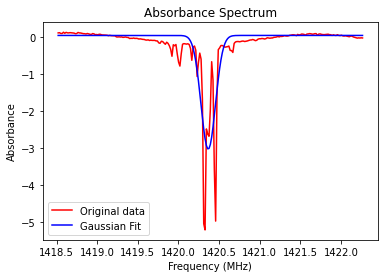

In [206]:
# fitting the gaussian to the absorbance data
plt.plot(abs_x_values, abs_y_values, 'r-', label='Original data')
baseline_abs = (abs_y_values[0] + abs_y_values[-1])/2
abs_mean, abs_sigma, abs_best_fit = fit_gaussian(abs_x_values, abs_y_values - baseline_abs)
print('Mean: ', abs_mean, ' Sigma: ', abs_sigma)
plt.plot(abs_x_values, abs_best_fit + baseline_abs, 'b-', label='Gaussian Fit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Absorbance')
plt.title('Absorbance Spectrum')
plt.legend()

Mean:  1420.3764180481683  Sigma:  0.08550050683299748


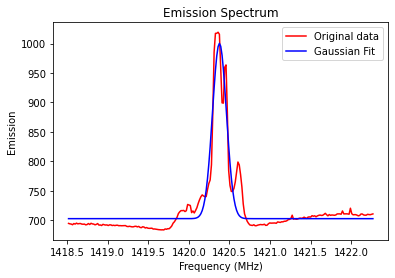

In [207]:
# fitting the gaussian to the emission data
plt.plot(ems_x_values, ems_y_values, 'r-', label='Original data')
baseline_ems = (ems_y_values[0] + ems_y_values[-1])/2
ems_mean, ems_sigma, ems_best_fit = fit_gaussian(ems_x_values, ems_y_values - baseline_ems)
print('Mean: ', ems_mean, ' Sigma: ', ems_sigma)
plt.plot(ems_x_values, ems_best_fit + baseline_ems, 'b-', label='Gaussian Fit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Emission')
plt.title('Emission Spectrum')
plt.legend()

As can be seen from the plot, the Gaussian fit frequency is nearly same for both the spectra. And the widths are also nearly same i.e., 0.089 for absobance and 0.086 for emission.

### 2. Determining the temperature of Emitting or Absorbing Gas.

$${\displaystyle \Delta f_{\text{FWHM}}={\sqrt {\frac {8kT\ln 2}{mc^{2}}}}f_{0}.}$$

Equation above represents the Doppler Broadening. Here $f_{0}$ is the frequency of the gas that emitted the light, $k$ is the Boltzmann constant, $T$ is the temperature of the gas, $Δf_{\text{FWHM}}$ is the line width that we calculated earlier and m is the mass of emmiting or absorbing particle. Thus we get the temperature of the gas to be $$ T = \frac{mc^{2} {Δf_{\text{FWHM}}}^2}{8k {f_0}^2 \ln(2)} $$
$$ {\displaystyle \mathrm {FWHM} =2{\sqrt {2\ln 2}}\;\sigma \approx 2.355\;\sigma .} $$

In [208]:
def temperature(sigma):
    # returns temp. in K.
    # sigma in Hz
    m_e = 9.10938356e-31
    c = 299792458
    k = 1.38064852e-23
    f_0 = c/(0.21) # =1427583133.33 Hz
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    return (m_e*(c**2)*(fwhm**2))/(8*k*(f_0**2)*np.log(2))

In [209]:
# Calculating the temperature
# for absorption
temp_abs = temperature(abs_sigma*1e+6)
# for emission
temp_ems = temperature(ems_sigma*1e+6)
print('Temperature for absorbing gas: ', temp_abs, ' K', ', with FWHM: ', 2.355*abs_sigma, ' MHz')
print('Temperature for emitting gas : ', temp_ems, ' K', ', with FWHM: ', 2.355*ems_sigma, ' MHz')

Temperature for absorbing gas:  23.121742961414803  K , with FWHM:  0.20993215919543592  MHz
Temperature for emitting gas :  21.270702086111616  K , with FWHM:  0.20135369359170907  MHz


### 3. Finding the RMS Noise spectrum.

In [210]:
noise_abs = abs_y_values - abs_best_fit - baseline_abs
rms_noise_abs = np.sqrt(np.mean(noise_abs**2))
print('RMS noise for absorption: ', rms_noise_abs)

noise_ems = ems_y_values - ems_best_fit - baseline_ems
rms_noise_ems = np.sqrt(np.mean(noise_ems**2))
print('RMS noise for emission: ', rms_noise_ems)

RMS noise for absorption:  0.4235724896438871
RMS noise for emission:  20.307384412518722


### 4. RMS across Band for 1822-096.offset.H1.abs.

In [211]:
# load the file
abs_offset_xy_values_pair = np.loadtxt('1822-096.offset.H1.abs', usecols=(1,2))
abs_offset_x_values = abs_offset_xy_values_pair[:,0]/1e+6 # in MHz
abs_offset_y_values = abs_offset_xy_values_pair[:,1]

abs_offset_y_values_new = abs_offset_y_values - np.mean(abs_offset_y_values)
rms_abs_noise = np.sqrt(np.mean(abs_offset_y_values_new**2))
print('RMS noise for absorption offset: ', rms_abs_noise)


RMS noise for absorption offset:  0.004250527047191216


### 5. RMS Noise for 3 cases.

In [212]:
def find_rms_noise(y):
    y_new = y - np.mean(y)
    return np.sqrt(np.mean(y_new**2))

#### 5a. RMS Noise for 1822-096.spl.1-16.30s.spec.

In [213]:
# load data
data1 = np.loadtxt('1822-096.spl.1-16.30s.spec', usecols=(3,5))
data1_x, data1_y = data1[:,0], data1[:,1]
print('RMS noise for 1822-096.spl.1-16.30s.spec: ', find_rms_noise(data1_y))

RMS noise for 1822-096.spl.1-16.30s.spec:  0.9998370762352958


#### 5b. RMS Noise for 1822-096.spl.1-16.5m.data.spec.

In [214]:
# load data
data2 = np.loadtxt('1822-096.spl.1-16.5m.data.spec', usecols=(3,5))
data2_x, data2_y = data2[:,0], data2[:,1]
print('RMS noise for 1822-096.spl.1-16.5m.data.spec: ', find_rms_noise(data2_y))

RMS noise for 1822-096.spl.1-16.5m.data.spec:  0.8344390071581923


#### 5c. RMS Noise for 1822-096.spl.full.data.vector.aver.spec.

In [215]:
# load data
data3 = np.loadtxt('1822-096.spl.full.data.vector.aver.spec', usecols=(3,5))
data3_x, data3_y = data3[:,0], data3[:,1]
print('RMS noise for 1822-096.spl.full.data.vector.aver.spec: ', find_rms_noise(data3_y))

RMS noise for 1822-096.spl.full.data.vector.aver.spec:  0.7938974657161026


#### 5d. RMS Noise Analysis
As can be seen from the above values that the RMS noise decreases for the three cases, i.e., 1822-096.spl.1-16.30s.spec, 1822-096.spl.1-16.5m.data.spec and 1822-096.spl.full.data.vector.aver.spec.